In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import os
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")

# Preparing Data

## Create SparkSession

In [2]:
spark = SparkSession.builder.appName("NYC_ETA").getOrCreate()

24/12/01 13:06:33 WARN Utils: Your hostname, une-petite-anhanh.local resolves to a loopback address: 127.0.0.1; using 172.16.1.50 instead (on interface en0)
24/12/01 13:06:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 13:06:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read Parquet Files

In [3]:
# Merge all data parquet files

jul_data_path = "../data/yellow_tripdata_2024-07.parquet"
aug_data_path = "../data/yellow_tripdata_2024-08.parquet"
sep_data_path = "../data/yellow_tripdata_2024-09.parquet"
df_jul = spark.read.parquet(jul_data_path)
df_aug = spark.read.parquet(aug_data_path)
df_sep = spark.read.parquet(sep_data_path)

df = df_jul.union(df_aug).union(df_sep)

output_path = "../data/merged_yellow_tripdata_2024_Q3.parquet"
# df.write.parquet(output_path)

df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|         1|                 N|         140|          79|           1|       15.6|  3.5|    0.5|       3.

In [4]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



![data_schema.png](./data_schema.png)

### Merge Taxi Zone Data

In [5]:
zones_df = spark.read.csv("../data/taxi_zone_lookup.csv", header=True, inferSchema=True)
zones_df.show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



#### Merge **zones_df** with **df** by **Pick Up Location**

In [6]:
df = df.join(zones_df, df.PULocationID == zones_df.LocationID, "inner")

df = df \
    .withColumnRenamed("Borough", "PU_Borough") \
    .withColumnRenamed("Zone", "PU_Zone") \
    .withColumnRenamed("service_zone", "PU_service_zone")

df = df.drop("LocationID")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|PU_Borough|             PU_Zone|PU_service_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+
|       1| 2024-07-01 00:34:56|  2024-07-01

#### Merge **zones_df** with **df** by **Drop Off Location**

In [7]:
df = df.join(zones_df, df.DOLocationID == zones_df.LocationID, "inner")

df = df \
    .withColumnRenamed("Borough", "DO_Borough") \
    .withColumnRenamed("Zone", "DO_Zone") \
    .withColumnRenamed("service_zone", "DO_service_zone")

df = df.drop("LocationID")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|PU_Borough|             PU_Zone|PU_service_zone|DO_Borough|             DO_Zone|DO_service_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------

#### Drop some irrelevant columns which has no or little impact in estimate time arrival

In [8]:
columns_to_drop = [
    "store_and_fwd_flag", 
    "payment_type", 
    "fare_amount", 
    "extra", 
    "mta_tax", 
    "tip_amount", 
    "tolls_amount", 
    "improvement_surcharge", 
    "total_amount", 
    "PU_service_zone", 
    "DO_service_zone"
]

df = df.drop(*columns_to_drop)

df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+-----------+----------+--------------------+----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|congestion_surcharge|Airport_fee|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+-----------+----------+--------------------+----------+--------------------+
|       1| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|         1|         140|          79|                 2.5|        0.0| Manhattan|     Lenox Hill East| Manhattan|        East Village|
|       2| 2024-06-30 23:48:58|  2024-07-01 00:28:04|              1|        19.48|         2|         132|         113|        

# Preprocessing Data

## Data Cleaning

#### trip_distance


In [9]:
from pyspark.sql.functions import col, mean as spark_mean, stddev

# Calculate mean and standard deviation
trip_dis_stats = df.select(
    spark_mean(col("trip_distance")).alias("mean"),
    stddev(col("trip_distance")).alias("stddev")
).collect()[0]
trip_dis_stats

Row(mean=5.296567671395089, stddev=433.93545298571394)

In [10]:
trip_dis_mean = trip_dis_stats["mean"]
trip_dis_stddev = trip_dis_stats["stddev"]

print(f"Mean for Trip Duration is: {trip_dis_mean}")
print(f"Standard Deviation for Trip Duration is: {trip_dis_stddev}")

# Filter rows within 2 standard deviations
df = df.filter(
    (col("trip_distance") >= trip_dis_mean - 2 * trip_dis_stddev) &
    (col("trip_distance") <= trip_dis_mean + 2 * trip_dis_stddev) &
    (col("trip_distance") >= 1)
)

df.describe().show()

Mean for Trip Duration is: 5.296567671395089
Standard Deviation for Trip Duration is: 433.93545298571394


24/12/01 13:06:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+--------------------+----------+--------------------+
|summary|          VendorID|   passenger_count|     trip_distance|        RatecodeID|      PULocationID|     DOLocationID|congestion_surcharge|        Airport_fee|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+--------------------+----------+--------------------+
|  count|           7463340|           6606139|           7463340|           6606139|           7463340|          7463340|             6606139|            6606139|   7463340|             7463340|   7463340|             7463340|
|   mean| 1.770373452100534|1.3486086199518357|4.4061404505223205|2.7390846604953363|160

#### passenger_count

Filter rows where `passenger_count` is 7, 8, 9 or 0 because it is uncommon in NYC taxi data
> *(most taxis accommodate up to 6 passengers)*

In [11]:
from pyspark.sql.functions import col
df = df.filter(~(col("passenger_count").isin([7, 8, 9, 0])))

##### airport_fee to enter_airport

In [12]:
from pyspark.sql.functions import when

df = df.withColumn(
    "enter_airport", 
    when(col("airport_fee") > 0, "1").otherwise("0")
)
df.select("enter_airport").show(5)


+-------------+
|enter_airport|
+-------------+
|            0|
|            1|
|            0|
|            1|
|            0|
+-------------+
only showing top 5 rows



In [13]:
df = df.drop("airport_fee")

##### pick_up and drop_off datetime

In [14]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss")) \
       .withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))

df.select("tpep_pickup_datetime", "tpep_dropoff_datetime").show(truncate=False)


+--------------------+---------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|
+--------------------+---------------------+
|2024-07-01 07:34:56 |2024-07-01 07:46:49  |
|2024-07-01 06:48:58 |2024-07-01 07:28:04  |
|2024-07-01 07:23:18 |2024-07-01 07:29:51  |
|2024-07-01 07:07:55 |2024-07-01 07:34:34  |
|2024-07-01 07:19:42 |2024-07-01 07:32:13  |
|2024-07-01 07:34:04 |2024-07-01 07:43:13  |
|2024-07-01 07:59:52 |2024-07-01 08:05:27  |
|2024-07-01 07:13:50 |2024-07-01 07:28:03  |
|2024-07-01 07:43:34 |2024-07-01 08:01:43  |
|2024-07-01 07:52:25 |2024-07-01 08:17:53  |
|2024-07-01 07:51:18 |2024-07-01 08:01:42  |
|2024-07-01 07:33:24 |2024-07-01 07:54:44  |
|2024-07-01 07:56:52 |2024-07-01 08:12:59  |
|2024-07-01 07:36:26 |2024-07-01 07:50:42  |
|2024-07-01 07:59:32 |2024-07-01 08:07:58  |
|2024-07-01 07:16:06 |2024-07-01 07:45:42  |
|2024-07-01 07:56:04 |2024-07-01 08:13:10  |
|2024-07-01 07:18:04 |2024-07-01 07:49:00  |
|2024-07-01 07:09:49 |2024-07-01 07:36:44  |
|2024-07-0

`tpep_pickup_datetime`

In [15]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

df = df.withColumn("pickup_date", F.to_date(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_hour", F.hour(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_minute", F.minute(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_second", F.second(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_weekday", F.dayofweek(F.col("tpep_pickup_datetime")) - 1)  # Adjust to 0-based (Sunday: 0, Monday: 1,...)
df = df.withColumn("pickup_month", F.month(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_day", F.day(F.col("tpep_pickup_datetime")))


# Weekly hour feature (captures patterns based on the time of day and the day of the week)
df = df.withColumn(
    "pickup_week_hour", F.col("pickup_weekday") * 24 + F.col("pickup_hour")  # 0 (Sunday midnight) to 167 (Saturday 11:00 PM)
)

df = df.withColumn(
    "pickup_time", 
    F.concat(
        F.lpad(F.col("pickup_hour"), 2, "0"), F.lit(":"),
        F.lpad(F.col("pickup_minute"), 2, "0"), F.lit(":"),
        F.lpad(F.col("pickup_second"), 2, "0")
    )
)

`tpep_dropoff_datetime`

In [16]:
df = df.withColumn("dropoff_date", F.to_date(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_hour", F.hour(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_minute", F.minute(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_second", F.second(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_weekday", F.dayofweek(F.col("tpep_dropoff_datetime")) - 1)  # Adjust to 0-based (Sunday: 0, Monday: 1,...)
df = df.withColumn("dropoff_month", F.month(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_day", F.day(F.col("tpep_dropoff_datetime")))

df = df.withColumn(
    "dropoff_time", 
    F.concat(
        F.lpad(F.col("dropoff_hour"), 2, "0"), F.lit(":"),
        F.lpad(F.col("dropoff_minute"), 2, "0"), F.lit(":"),
        F.lpad(F.col("dropoff_second"), 2, "0")
    )
)

df.select(
    "pickup_date", "pickup_time" , "pickup_month", "pickup_day", "pickup_weekday", "pickup_hour", "pickup_minute", "pickup_second", 
    "pickup_week_hour", "dropoff_date", "dropoff_time" , "dropoff_month", "dropoff_day", "dropoff_hour", "dropoff_minute", "dropoff_second"
).show(truncate=False)


+-----------+-----------+------------+----------+--------------+-----------+-------------+-------------+----------------+------------+------------+-------------+-----------+------------+--------------+--------------+
|pickup_date|pickup_time|pickup_month|pickup_day|pickup_weekday|pickup_hour|pickup_minute|pickup_second|pickup_week_hour|dropoff_date|dropoff_time|dropoff_month|dropoff_day|dropoff_hour|dropoff_minute|dropoff_second|
+-----------+-----------+------------+----------+--------------+-----------+-------------+-------------+----------------+------------+------------+-------------+-----------+------------+--------------+--------------+
|2024-07-01 |07:34:56   |7           |1         |1             |7          |34           |56           |31              |2024-07-01  |07:46:49    |7            |1          |7           |46            |49            |
|2024-07-01 |06:48:58   |7           |1         |1             |6          |48           |58           |30              |2024-07-01 

In [17]:
df = df.withColumn(
    "trip_duration_seconds", 
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) 
)
df = df.filter(col("trip_duration_seconds") <= 100000)
df.select("trip_duration_seconds").show(5)


+---------------------+
|trip_duration_seconds|
+---------------------+
|                  713|
|                 2346|
|                  393|
|                 1599|
|                  751|
+---------------------+
only showing top 5 rows



##### speed in miles per hour

In [18]:
df = df.withColumn("speed_mph", F.col("trip_distance") / (F.col("trip_duration_seconds") / 3600))
min_speed = 0
max_speed = 100

df = df.filter((F.col("speed_mph") >= min_speed) & (F.col("speed_mph") <= max_speed))
df.select("speed_mph").describe().show(5)

+-------+-------------------+
|summary|          speed_mph|
+-------+-------------------+
|  count|            6542820|
|   mean| 12.102007497500196|
| stddev|  6.939553089653907|
|    min|0.04170335016913025|
|    max|              100.0|
+-------+-------------------+



#### Visualize the Total trip duration throughout a day every day in July

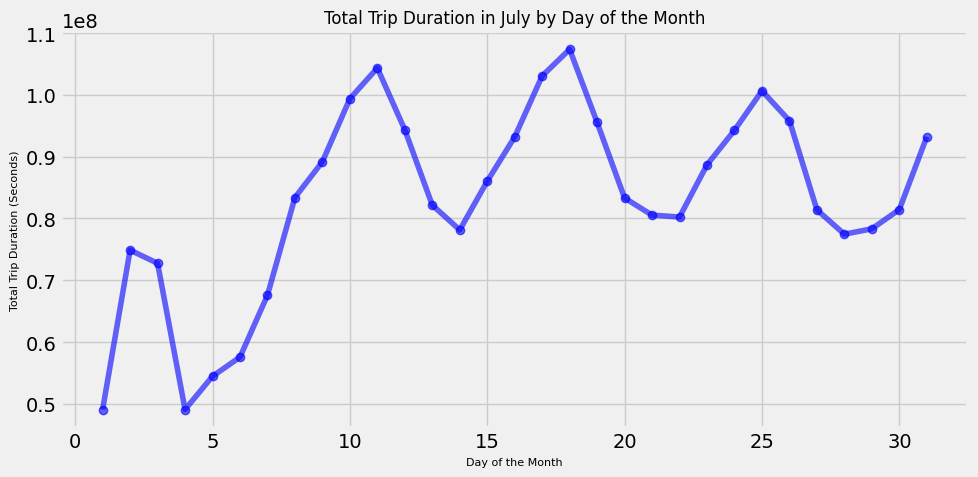

In [19]:
july_data = df.filter(F.col("pickup_month") == 7)

july_data = july_data.groupBy("pickup_day").agg(
    F.sum("trip_duration_seconds").alias("total_trip_duration_seconds"),
    F.count("pickup_day").alias("trip_count")
)

july_data = july_data.orderBy("pickup_day")

pandas_july_data = july_data.toPandas()

plt.figure(figsize=(10, 5))

plt.plot(pandas_july_data['pickup_day'], pandas_july_data['total_trip_duration_seconds'], linestyle='-', marker='o', color='b', alpha=0.6)

plt.title('Total Trip Duration in July by Day of the Month', fontsize=12)
plt.xlabel('Day of the Month', fontsize=8)
plt.ylabel('Total Trip Duration (Seconds)', fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()


#### Visualize the number of trips occur in each hour throughout a day

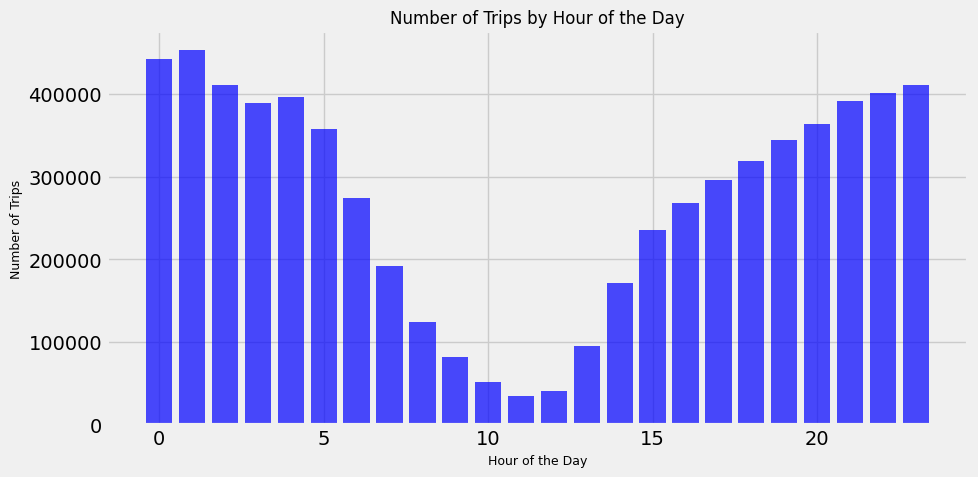

In [20]:
hourly_trip_count = df.groupBy("pickup_hour").agg(
    F.count("pickup_hour").alias("trip_count")
)

hourly_trip_count = hourly_trip_count.orderBy("pickup_hour")

pandas_hourly_trip_count = hourly_trip_count.toPandas()

plt.figure(figsize=(10, 5))

plt.bar(pandas_hourly_trip_count['pickup_hour'], pandas_hourly_trip_count['trip_count'], color='b', alpha=0.7)

plt.title('Number of Trips by Hour of the Day', fontsize=12)
plt.xlabel('Hour of the Day', fontsize=9)
plt.ylabel('Number of Trips', fontsize=9)

plt.grid(True)
plt.tight_layout() 
plt.show()


In [21]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+-----------+------------+------------+--------------+--------------+---------------+-------------+-----------+------------+---------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|congestion_surcharge|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|pickup_time|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dropoff_month|dropoff_day|dropoff_time|trip_duration_seconds|         speed_mph|
+--------+------

### Location

#### Borough having the most number of trips

In [22]:
pickup_borough_counts = df.groupBy("PU_Borough").count()
dropoff_borough_counts = df.groupBy("DO_Borough").count()

In [23]:
pickup_borough_counts_pd = pickup_borough_counts.toPandas()
dropoff_borough_counts_pd = dropoff_borough_counts.toPandas()

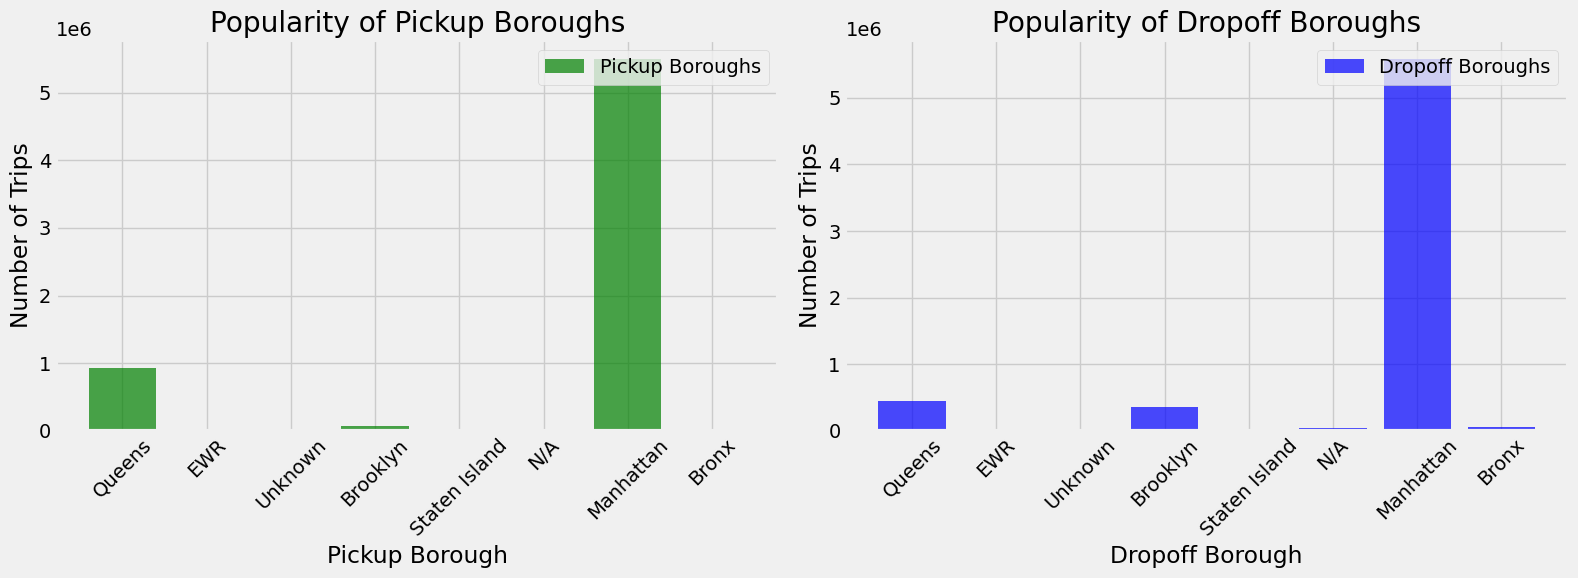

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].bar(pickup_borough_counts_pd['PU_Borough'], pickup_borough_counts_pd['count'], color='green', alpha=0.7, label='Pickup Boroughs')
ax[0].set_xlabel('Pickup Borough')
ax[0].set_ylabel('Number of Trips')
ax[0].set_title('Popularity of Pickup Boroughs')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(loc='upper right')

ax[1].bar(dropoff_borough_counts_pd['DO_Borough'], dropoff_borough_counts_pd['count'], color='blue', alpha=0.7, label='Dropoff Boroughs')
ax[1].set_xlabel('Dropoff Borough')
ax[1].set_ylabel('Number of Trips')
ax[1].set_title('Popularity of Dropoff Boroughs')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Checking the Correlation between Features

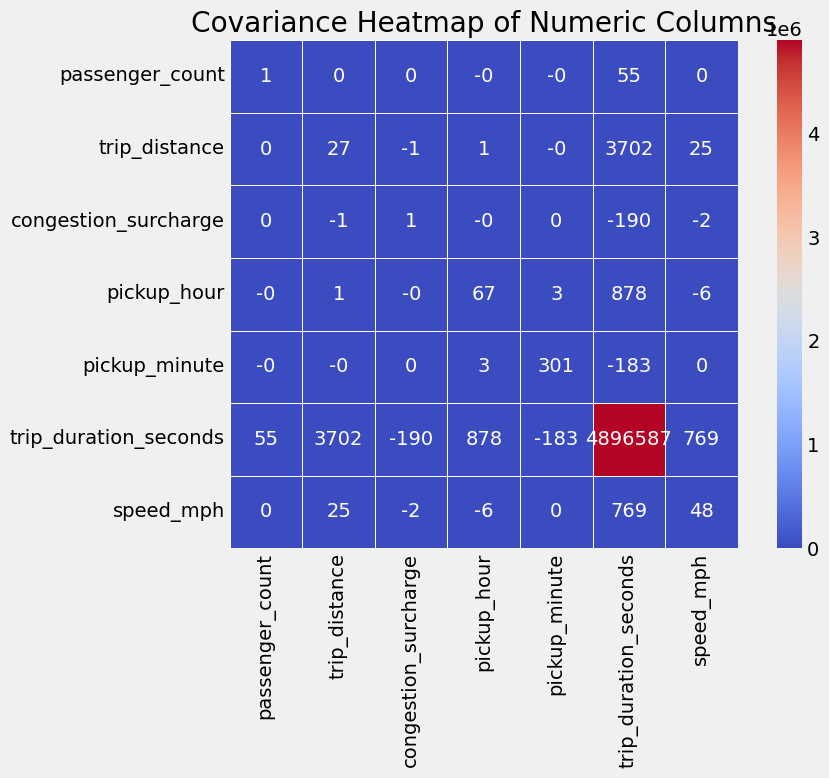

In [25]:
numeric_columns = [
    "passenger_count", "trip_distance", "congestion_surcharge",
    "pickup_hour", "pickup_minute", "trip_duration_seconds", "speed_mph"
]

numeric_df = df.select(numeric_columns).sample(fraction=0.1, seed=42).toPandas()

covariance_matrix = numeric_df.cov()

plt.figure(figsize=(10, 8))
sns.heatmap(
    covariance_matrix,
    annot=True, 
    cmap="coolwarm",
    fmt=".0f",  
    cbar=True,  
    square=True, 
    linewidths=0.5 
)
plt.title("Covariance Heatmap of Numeric Columns")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Adding Weather dataset


In [26]:
weather_dataset = pd.read_csv("../data/weather_data_2024.csv")
weather_dataset.columns = weather_dataset.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
weather_dataset.head()

,date,maximum_temperature,minimum_temperature,average_temperature,precipitation,snow_fall,snow_depth
0,2024-07-01,79,66,72.5,0.83,0,0
1,2024-07-02,76,63,69.5,0,0,0
2,2024-07-03,78,64,71.0,0,0,0
3,2024-07-04,84,66,75.0,0.49,0,0
4,2024-07-05,86,69,77.5,0.66,0,0


In [27]:
weather_dataset["date"] = pd.to_datetime(weather_dataset["date"])

weather_spark_df = spark.createDataFrame(weather_dataset)

df = df.join(weather_spark_df, df.pickup_date == weather_spark_df.date, "left")

df = df.drop(weather_spark_df.date)

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+-----------+------------+------------+--------------+--------------+---------------+-------------+-----------+------------+---------------------+------------------+-------------------+-------------------+-------------------+-------------+---------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|congestion_surcharge|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|pickup_time|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dr

In [28]:
columns_to_drop = [
    "maximum temperature", "minimum temperature", "average temperature", "snow fall", "snow depth"
]

df = df.drop(*columns_to_drop)

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+-----------+------------+------------+--------------+--------------+---------------+-------------+-----------+------------+---------------------+------------------+-------------------+-------------------+-------------------+-------------+---------+----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|congestion_surcharge|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|pickup_time|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dr

In [29]:
scatter = df[['average_temperature', 'precipitation', 'snow_fall', 'snow_depth']].sample(fraction=0.1, seed=42).toPandas()

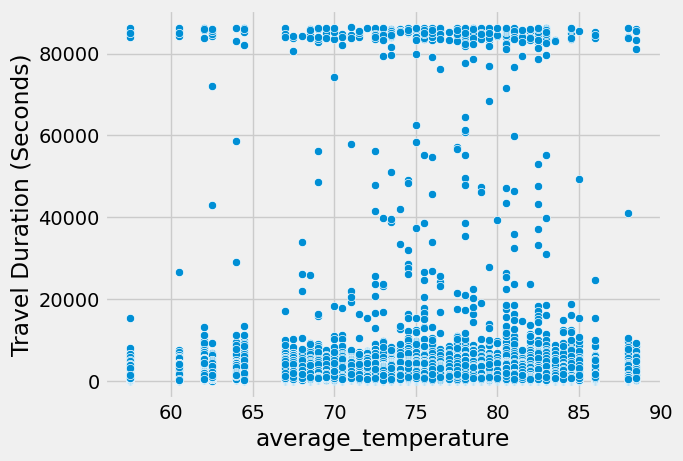

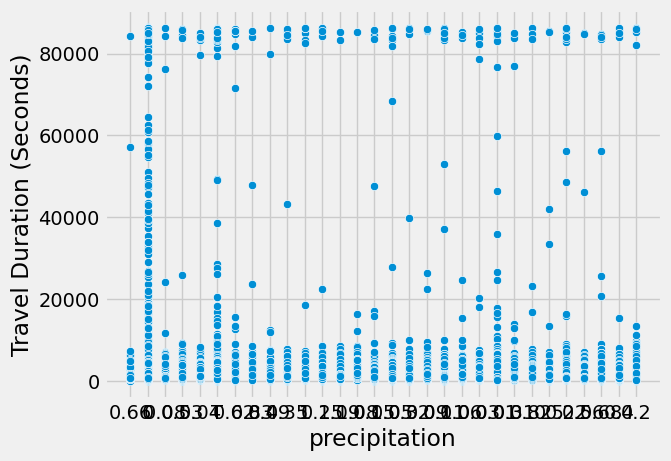

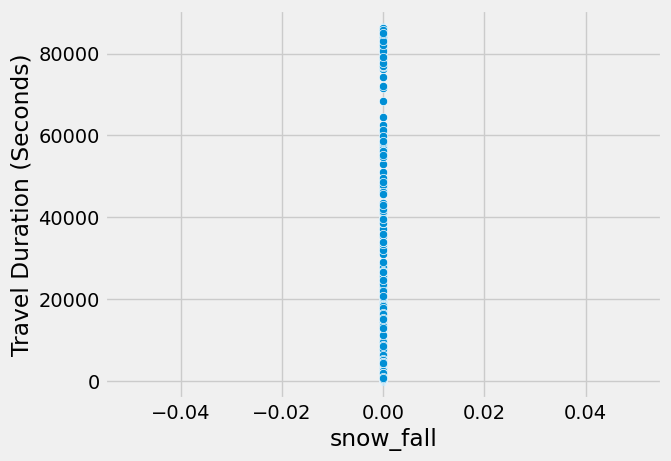

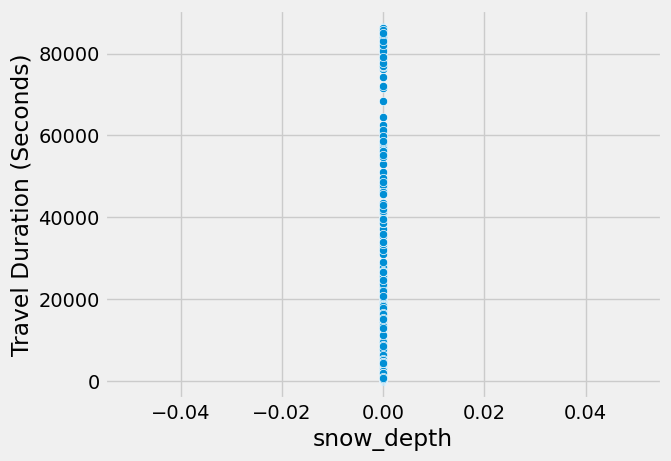

In [30]:
trip_duration_seconds_pd = df.select("trip_duration_seconds").sample(fraction=0.1, seed=42).toPandas()

for i in scatter.columns:
    sns.scatterplot(x=scatter[i], y=trip_duration_seconds_pd['trip_duration_seconds'])
    plt.ylabel('Travel Duration (Seconds)')
    plt.show()

base on the visualization we can drop column snow_fall and snow_depth because observing no noticeable trend or infomation

In [31]:
df = df.drop('snow_fall', 'snow_depth')

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

temperature_data = df.select("minimum_temperature", "average_temperature", "maximum_temperature", "pickup_day").toPandas()
# Create a new figure
fig = go.Figure()

# Add traces for minimum, average, and maximum temperature
colors = ['yellow', 'orange', 'red']
fig.add_trace(go.Scatter(x=temperature_data['pickup_day'], y=temperature_data['minimum_temperature'], mode='lines', line=dict(color=colors[0]), name='Minimum Temperature'))
fig.add_trace(go.Scatter(x=temperature_data['pickup_day'], y=temperature_data['average_temperature'], mode='lines', line=dict(color=colors[1]), name='Average Temperature'))
fig.add_trace(go.Scatter(x=temperature_data['pickup_day'], y=temperature_data['maximum_temperature'], mode='lines', line=dict(color=colors[2]), name='Maximum Temperature'))

# Add trace for trip count
trip_count_data = df.groupBy("pickup_day").agg(F.count("pickup_day").alias("trip_count")).orderBy("pickup_day").toPandas()
fig.add_trace(go.Scatter(x=trip_count_data['pickup_day'], y=trip_count_data['trip_count'], mode='lines', line=dict(color='blue'), name='Trip Count'))

# Show the figure
fig.show()